# Hematological and platelet-derived inflammatory markers in relation to androgen excess in women with PCOS  
## Statistical analysis notebook

**Notebook:** 03_analysis.ipynb  

**Version:** v1.1

**Author:** Natalia Piórkowska

**Date:** 2025-02-15  


### Aim
This notebook provides a reproducible workflow to evaluate associations between androgen excess markers and CBC-derived platelet/inflammatory indices in women with PCOS, using:
- an **available-case** dataset (AC) for the main analysis, and  
- a **complete-case** dataset (CC) for sensitivity analysis.

**Primary inference** is based on the available-case dataset (AC).  
Complete-case results (CC) are reported as sensitivity analyses to evaluate robustness to missing-data restrictions.


### Pre-specified analysis
**Primary predictors:** FAI, total testosterone, DHEAS.  
**Primary outcomes:** platelet activation indices (MPV, PDW, P-LCR) and inflammation-related indices (RDW, NLR, PLR).  
**Secondary/exploratory outcomes:** additional CBC variables (e.g., PLT, PCT, RDW-SD, WBC, monocytes, MPR).

**Insulin resistance (IR):** HOMA-IR is the main IR index (log-transformed for regression stability). QUICKI and TyG are computed for descriptive/sensitivity purposes only and are not entered jointly into the same regression models to avoid collinearity.

### Statistical methods
- Spearman correlations with Benjamini–Hochberg FDR correction **within pre-defined families of tests**.
- OLS regression with **HC3 robust standard errors**:
  - crude: `marker ~ androgen`
  - IR-adjusted: `marker ~ androgen + log(HOMA-IR)`
  - IR+age-adjusted: `marker ~ androgen + log(HOMA-IR) + age` (if age is available)

### Notes
Cross-sectional design; associations do not imply causality. Residual confounding (e.g., adiposity) may persist when BMI is unavailable.

BMI was not available and therefore could not be included as an adjustment covariate.  
Interpretation of androgen–CBC associations accounts for potential residual confounding by adiposity.




### **Imports and reproducibility**

In [1]:
import os
import sys
import platform
from pathlib import Path
import re

import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 250)
pd.set_option("display.max_rows", 200)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving outputs to:", OUT_DIR.resolve())


Saving outputs to: /content/outputs


## Paths (AC/CC) + session info


In [3]:
import scipy

AC_PATH = "/content/cleaned_PCOS_df_main_available_case.xlsx"
CC_PATH = "/content/cleaned_PCOS_df_cc_complete_case.xlsx"

print("AC file:", AC_PATH)
print("CC file:", CC_PATH)

def write_session_info(outdir: Path) -> Path:
    info = {
        "python": sys.version.replace("\n", " "),
        "platform": platform.platform(),
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scipy": scipy.__version__,
        "statsmodels": sm.__version__,
    }
    path = outdir / "session_info.txt"
    with open(path, "w", encoding="utf-8") as f:
        for k, v in info.items():
            f.write(f"{k}: {v}\n")
    return path

session_path = write_session_info(OUT_DIR)
print("Saved session info:", session_path)

AC file: /content/cleaned_PCOS_df_main_available_case.xlsx
CC file: /content/cleaned_PCOS_df_cc_complete_case.xlsx
Saved session info: outputs/session_info.txt


## Load AC/CC

In [3]:
df_ac_raw = pd.read_excel(AC_PATH)
df_cc_raw = pd.read_excel(CC_PATH)

print("AC shape:", df_ac_raw.shape)
print("CC shape:", df_cc_raw.shape)

display(df_ac_raw.head(3))


AC shape: (1300, 206)
CC shape: (905, 206)


,Nr KG,Rok KG,Przyjęcie na oddział zlecający,Wypis z oddziału zlecającego,Wiek,17 - OH progesteron (L79) (17-OHPG),17 OH progesteron (L79),ALAT (ALT),AMH,AMH-anty Mullerian Hormon (AMH),APTT Czas kaolinowo-kefalinowy (APTTCZ),ASO - ilościowo (ASOIL),ASPAT (AST),Androstendion (I31),Androstendion (I31) (ANDRO),Anty - HCV (L_ANTHCV),Anty-TG (O18),Anty-TG (p/c przeciw tyreoglobulinie) (ATG),Anty-TPO (ATA_TPO),Białko C-reaktywne (CRP),Bilirubina całkowita (TBIL),CEA (CEA),Ca125 (CA125),Ca19.9 (CA199),Cholesterol całkowity (TCHOL),D-dimery (DDIMER),DHEAS,Dobowy rytm tolerancji glukozy (L_G1030),Dobowy rytm tolerancji glukozy (L_G1200),Dobowy rytm tolerancji glukozy (L_G1500),Dobowy rytm tolerancji glukozy (L_G1800),Dobowy rytm tolerancji glukozy (L_G2100),Dobowy rytm tolerancji glukozy (L_G2400),Dobowy rytm tolerancji glukozy (L_G330),Dobowy rytm tolerancji glukozy (L_G700),Dokument (NAZWA),Estradiol (ESTRA),Estradiol (L_ESTRA),FSH,FSH 0' 30' 60' (L_FSH0),FSH 0' 30' 60' (L_FSH30),FSH 0' 30' 60' (L_FSH60),FT3 (FT3),FT4 (FT4),Ferrytyna (FERR),Ferrytyna (L05),Fibrynogen (L_FIB),Fosforany nieorganiczne (FOSFOR),GH (hormon wzrostu) (L_GH),Gamma Glutamylotranspeptydaza (GGTP),Glukoza (L_GLU),"Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (COV2_G)","Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (GRYA)","Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (GRYB)","Grypa A, B, RSV, SARS-CoV2 antygen - badanie jakościowe (GRYRSV)",HBSAG (L_HBSAG),HBsAg (L_HBSAG),HDL cholesterol (HDL),HbsAg (HBSAG),Hemoglobina glikowana (HBA1C_1),Hemoglobina glikowana (HBA1C_2),Hemoglobina glikowana (L53.IFC),Hemoglobina glikowana (L55),IGF-1 (insulinopodobny czynnik wzrostu 1) (IGF1_L),Insulina (INSUL),Insulina po 75g glukozy (3pkt.) (INSUL_0),Insulina po 75g glukozy (3pkt.) (INSUL_1),Insulina po 75g glukozy (3pkt.) (INSUL_2),"Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 0m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 120m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 30m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97 60m)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97_0)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97_1)","Insulina po obciążeniu 75 g glukozy 0,1,2,3 (L97_2)","Jonogram (Sód, potas, chlorki) (L_CI)","Jonogram (Sód, potas, chlorki) (L_K)","Jonogram (Sód, potas, chlorki) (L_NA)",Kortyzol godz. 08:00 (KOR),Kortyzol godz. 23:00 (KOR23),Kortyzol na czczo (KORCZ),Kortyzol po Dexamethasonie (KORD),Kortyzol po Dexamethasonie [1mg] (KORD),Kortyzol po Dexamethasonie [2mg] (KOR2DXM),Kortyzol po Dexamethasonie [4mg] (KOR4DXM),Kreatynina (KREAT),Krzywa cukrowa - 2 punktowa (GLU120),Krzywa cukrowa - 2 punktowa (L_GLU_0),LDL cholesterol (LDL),LH,LH 0' 30' 60' (LH0),LH 0' 30' 60' (L_LH30),LH 0' 30' 60' (L_LH60),MDRD GFR (MDRD),Mocz - badanie ogólne (MBARWA),Mocz - badanie ogólne (MBIALK),Mocz - badanie ogólne (MBILI),Mocz - badanie ogólne (MCIEZA),Mocz - badanie ogólne (MCUKIE),Mocz - badanie ogólne (MERY),Mocz - badanie ogólne (MKETON),Mocz - badanie ogólne (MLEU),Mocz - badanie ogólne (MNIT),Mocz - badanie ogólne (MOSAD),Mocz - badanie ogólne (MPH),Mocz - badanie ogólne (MPRZEJ),Mocz - badanie ogólne (MUROBI),Morfologia CBC (HCT),Morfologia CBC (HGB),Morfologia CBC (MCH),Morfologia CBC (MCHC),Morfologia CBC (MCV),Morfologia CBC (MPV),Morfologia CBC (NRBC_B),Morfologia CBC (NRBC_P),Morfologia CBC (PCT),Morfologia CBC (PDW),Morfologia CBC (PLCR),Morfologia CBC (PLT),Morfologia CBC (RBC),Morfologia CBC (RDW),Morfologia CBC (RDWSD),Morfologia CBC (WBC),BASO,BASOB,EOS#,EOS,"Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (HCT)","Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (HGB)",IG_B,IG_P,LIM#,"Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (LIM)","Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (MCH)","Morfologia krwi, z pełnym różnicowaniem granulocytów 

## Robust numeric coercion for any object columns (Polish commas, qualifiers)

In [4]:
def parse_polish_numeric(series: pd.Series) -> pd.Series:
    """Convert object columns like '77,6' to float; non-numeric -> NaN."""
    if not pd.api.types.is_object_dtype(series):
        return series

    x = series.astype(str).str.strip()
    x = x.replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan, "-": np.nan, "--": np.nan})
    x = x.str.replace(r"[<>=≤≥]", "", regex=True)
    x = x.str.replace(" ", "", regex=False).str.replace(",", ".", regex=False)
    return pd.to_numeric(x, errors="coerce")

def coerce_all_object_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    obj_cols = [c for c in out.columns if pd.api.types.is_object_dtype(out[c])]
    for c in obj_cols:
        out[c] = parse_polish_numeric(out[c])
    return out

def to_numeric_pl(series: pd.Series) -> pd.Series:
    s = series.astype("string")
    s = s.str.replace("\u00A0", " ", regex=False).str.strip()
    s = s.str.replace(",", ".", regex=False)
    s = s.str.replace(r"[<>]=?", "", regex=True)

    extracted = s.str.extract(r"(-?\d+(?:\.\d+)?)", expand=False)

    return pd.to_numeric(extracted, errors="coerce")

df_ac = coerce_all_object_columns(df_ac_raw)
df_cc = coerce_all_object_columns(df_cc_raw)

print("AC object cols after parsing:", sum(pd.api.types.is_object_dtype(df_ac[c]) for c in df_ac.columns))
print("CC object cols after parsing:", sum(pd.api.types.is_object_dtype(df_cc[c]) for c in df_cc.columns))


AC object cols after parsing: 0
CC object cols after parsing: 0


In [5]:
def pick_first_present(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None


CANON = {
    # androgens
    "testosterone": ["Testosteron", "TESTO_TOTAL", "TESTO", "TESTOSTERON"],
    "dheas": ["DHEAS", "DHEA_S", "DHEA-S"],
    "shbg": ["SHBG"],
    "fai": ["FAI"],

    # gonadotropins
    "lh": ["LH"],
    "fsh": ["FSH"],
    "lh_fsh": ["LH_FSH", "LH_FSH_ratio", "LH_FSH"],

    # CBC / indices
    "mpv": ["MPV", "Morfologia CBC (MPV)"],
    "pdw": ["PDW", "Morfologia CBC (PDW)"],
    "p_lcr": ["PLCR", "P-LCR", "Morfologia CBC (PLCR)"],
    "rdw": ["RDW", "Morfologia CBC (RDW)"],
    "rdw_sd": ["RDWSD", "RDW-SD", "Morfologia CBC (RDWSD)"],
    "plt": ["PLT", "Morfologia CBC (PLT)"],
    "pct": ["PCT", "Morfologia CBC (PCT)"],
    "wbc": ["WBC", "Morfologia CBC (WBC)",
            "Morfologia krwi, z pełnym różnicowaniem granulocytów (leukocytów) z rozmazem - 5 Diff (WBC)"],
    "neut_abs": ["NEUT#", "NEUT_ABS"],
    "lym_abs": ["LIM#", "LYMPH#", "LYMPH_ABS"],
    "mon_abs": ["MON#"],

    "nlr": ["NLR"],
    "plr": ["PLR"],
    "mpr": ["MPR"],

    # age
    "age": ["Wiek", "AGE", "Age"],
}

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    rename_map = {}
    for canon, cands in CANON.items():
        src = pick_first_present(out, cands)
        if src is not None:
            rename_map[src] = canon
    out = out.rename(columns=rename_map)
    return out

ac = standardize_columns(df_ac)
cc = standardize_columns(df_cc)

print("Standardized columns in AC:", sorted(set(CANON.keys()).intersection(ac.columns)))
print("Standardized columns in CC:", sorted(set(CANON.keys()).intersection(cc.columns)))


Standardized columns in AC: ['age', 'dheas', 'fai', 'fsh', 'lh', 'lh_fsh', 'lym_abs', 'mon_abs', 'mpr', 'mpv', 'neut_abs', 'nlr', 'p_lcr', 'pct', 'pdw', 'plr', 'plt', 'rdw', 'rdw_sd', 'shbg', 'testosterone', 'wbc']
Standardized columns in CC: ['age', 'dheas', 'fai', 'fsh', 'lh', 'lh_fsh', 'lym_abs', 'mon_abs', 'mpr', 'mpv', 'neut_abs', 'nlr', 'p_lcr', 'pct', 'pdw', 'plr', 'plt', 'rdw', 'rdw_sd', 'shbg', 'testosterone', 'wbc']


## Derived indices (FAI, LH/FSH, NLR, PLR, MPR)

In [6]:
def safe_div(a: pd.Series, b: pd.Series) -> pd.Series:
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce").replace({0: np.nan})
    return a / b

for d in (ac, cc):
    if "fai" not in d.columns and {"testosterone", "shbg"}.issubset(d.columns):
        d["fai"] = 100.0 * safe_div(d["testosterone"], d["shbg"])

    if "lh_fsh" not in d.columns and {"lh", "fsh"}.issubset(d.columns):
        d["lh_fsh"] = safe_div(d["lh"], d["fsh"])

    if "nlr" not in d.columns and {"neut_abs", "lym_abs"}.issubset(d.columns):
        d["nlr"] = safe_div(d["neut_abs"], d["lym_abs"])

    if "plr" not in d.columns and {"plt", "lym_abs"}.issubset(d.columns):
        d["plr"] = safe_div(d["plt"], d["lym_abs"])

    if "mpr" not in d.columns and {"mpv", "plt"}.issubset(d.columns):
        d["mpr"] = safe_div(d["mpv"], d["plt"])

display(ac[[c for c in ["fai","lh_fsh","nlr","plr","mpr"] if c in ac.columns]].head(5))


,fai,lh_fsh,nlr,plr,mpr
0,1.326498,NaN,2.934498,152.401747,0.029226
1,1.127962,0.565138,0.801802,66.366366,0.046154
2,1.083151,0.803698,0.916000,122.000000,0.032131
3,1.439024,1.900685,0.854305,74.172185,0.051339
4,0.489855,1.439878,1.611307,113.780919,0.031366


In [7]:
GLU0_CANDS = [
    "Krzywa cukrowa - 2 punktowa (L_GLU_0)",
    "L_GLU_0",
    "GLU0",
    "GLU_0",
]
GLU120_CANDS = [
    "Krzywa cukrowa - 2 punktowa (GLU120)",
    "GLU120",
    "GLU_120",
]
INS0_CANDS = [
    "Insulina po 75g glukozy (3pkt.) (INSUL_0)",
    "INSUL_0",
    "Insulina po 75g glukozy (3pkt.) (L97_0)",
    "L97_0",
    "Insulina po 75g glukozy (3pkt.) (L97 0m)",
    "L97 0m",
    "Insulina (INSUL)",
    "INSUL",
]
TG_CANDS = ["Triglicerydy (TG)", "TG", "TRIG", "Triglicerydy"]

def add_glucose_insulin_columns(df_std: pd.DataFrame, df_raw: pd.DataFrame) -> pd.DataFrame:
    out = df_std.copy()

    glu0 = pick_first_present(df_raw, GLU0_CANDS)
    glu120 = pick_first_present(df_raw, GLU120_CANDS)
    ins0 = pick_first_present(df_raw, INS0_CANDS)
    tg = pick_first_present(df_raw, TG_CANDS)

    if glu0 is not None:
        out["glucose_0"] = to_numeric_pl(df_raw[glu0])
    else:
        out["glucose_0"] = np.nan

    if glu120 is not None:
        out["glucose_120"] = to_numeric_pl(df_raw[glu120])

    if ins0 is not None:
        out["insulin"] = to_numeric_pl(df_raw[ins0])
    else:
        out["insulin"] = np.nan

    if tg is not None:
        out["triglycerides"] = to_numeric_pl(df_raw[tg])

    print("Resolved OGTT/Metabolic columns:")
    print("  glucose_0  <-", glu0)
    print("  glucose_120<-", glu120)
    print("  insulin    <-", ins0)
    print("  TG         <-", tg)

    return out


In [8]:
ac = add_glucose_insulin_columns(ac, df_ac)
cc = add_glucose_insulin_columns(cc, df_cc)

print("INSUL non-missing ac:", ac["insulin"].notna().sum(), " / ", len(ac))
print("INSUL preview:", ac["insulin"].dropna().head(10).tolist())
display(ac[["insulin", "glucose_0"]].head(10))


Resolved OGTT/Metabolic columns:
  glucose_0  <- Krzywa cukrowa - 2 punktowa (L_GLU_0)
  glucose_120<- Krzywa cukrowa - 2 punktowa (GLU120)
  insulin    <- Insulina po 75g glukozy (3pkt.) (INSUL_0)
  TG         <- Triglicerydy (TG)
Resolved OGTT/Metabolic columns:
  glucose_0  <- Krzywa cukrowa - 2 punktowa (L_GLU_0)
  glucose_120<- Krzywa cukrowa - 2 punktowa (GLU120)
  insulin    <- Insulina po 75g glukozy (3pkt.) (INSUL_0)
  TG         <- Triglicerydy (TG)
INSUL non-missing ac: 224  /  1300
INSUL preview: [5.62, 9.65, 5.29, 9.68, 12.9, 9.13, 6.44, 6.72, 5.09, 13.9]


,insulin,glucose_0
0,<NA>,92.0
1,<NA>,88.2
2,<NA>,84.5
3,<NA>,89.7
4,<NA>,85.3
5,<NA>,80.3
6,<NA>,88.2
7,<NA>,81.9
8,<NA>,76.9
9,<NA>,79.9


In [9]:


def coalesce_numeric_from_candidates(df_raw: pd.DataFrame, candidates: list[str], *, debug_name="value") -> tuple[pd.Series, dict]:

    present = [c for c in candidates if c in df_raw.columns]
    stats = {}

    if not present:
        return pd.Series([np.nan] * len(df_raw), index=df_raw.index), stats

    parsed_cols = []
    for c in present:
        s = to_numeric_pl(df_raw[c])
        stats[c] = int(s.notna().sum())
        parsed_cols.append(s)


    out = parsed_cols[0].copy()
    for s in parsed_cols[1:]:
        out = out.where(out.notna(), s)

    if present:
        print(f"[{debug_name}] non-missing per candidate:")
        for k, v in sorted(stats.items(), key=lambda kv: kv[1], reverse=True):
            print(f"  {k}: {v}")

    return out, stats


In [10]:
def add_glucose_insulin_columns(df_std: pd.DataFrame, df_raw: pd.DataFrame) -> pd.DataFrame:
    out = df_std.copy()


    glucose0, _ = coalesce_numeric_from_candidates(df_raw, GLU0_CANDS, debug_name="glucose_0")
    glucose120, _ = coalesce_numeric_from_candidates(df_raw, GLU120_CANDS, debug_name="glucose_120")
    insulin, ins_stats = coalesce_numeric_from_candidates(df_raw, INS0_CANDS, debug_name="insulin")
    tg, _ = coalesce_numeric_from_candidates(df_raw, TG_CANDS, debug_name="triglycerides")

    out["glucose_0"] = glucose0.to_numpy()
    if glucose120.notna().any():
        out["glucose_120"] = glucose120.to_numpy()

    out["insulin"] = insulin.to_numpy()
    if tg.notna().any():
        out["triglycerides"] = tg.to_numpy()

    print("Resolved OGTT/Metabolic columns (coalesced):")
    print("  glucose_0   <-", [c for c in GLU0_CANDS if c in df_raw.columns])
    print("  glucose_120 <-", [c for c in GLU120_CANDS if c in df_raw.columns])
    print("  insulin     <-", [c for c in INS0_CANDS if c in df_raw.columns])
    print("  TG          <-", [c for c in TG_CANDS if c in df_raw.columns])


    print("Final non-missing counts:")
    print("  glucose_0:", int(pd.Series(out["glucose_0"]).notna().sum()))
    print("  insulin  :", int(pd.Series(out["insulin"]).notna().sum()))

    return out


In [11]:
ac = add_glucose_insulin_columns(ac, df_ac)
cc = add_glucose_insulin_columns(cc, df_cc)

display(ac[["insulin","glucose_0"]].head(10))
display(ac.loc[ac["insulin"].notna(), ["insulin","glucose_0"]].head(10))
print("INSUL non-missing ac:", ac["insulin"].notna().sum(), "/", len(ac))


[glucose_0] non-missing per candidate:
  Krzywa cukrowa - 2 punktowa (L_GLU_0): 1160
[glucose_120] non-missing per candidate:
  Krzywa cukrowa - 2 punktowa (GLU120): 1159
[insulin] non-missing per candidate:
  Insulina (INSUL): 751
  Insulina po 75g glukozy (3pkt.) (INSUL_0): 224
[triglycerides] non-missing per candidate:
  Triglicerydy (TG): 1173
Resolved OGTT/Metabolic columns (coalesced):
  glucose_0   <- ['Krzywa cukrowa - 2 punktowa (L_GLU_0)']
  glucose_120 <- ['Krzywa cukrowa - 2 punktowa (GLU120)']
  insulin     <- ['Insulina po 75g glukozy (3pkt.) (INSUL_0)', 'Insulina (INSUL)']
  TG          <- ['Triglicerydy (TG)']
Final non-missing counts:
  glucose_0: 1160
  insulin  : 975
[glucose_0] non-missing per candidate:
  Krzywa cukrowa - 2 punktowa (L_GLU_0): 888
[glucose_120] non-missing per candidate:
  Krzywa cukrowa - 2 punktowa (GLU120): 888
[insulin] non-missing per candidate:
  Insulina (INSUL): 744
  Insulina po 75g glukozy (3pkt.) (INSUL_0): 149
[triglycerides] non-missin

,insulin,glucose_0
0,11.90,92.0
1,10.20,88.2
2,20.70,84.5
3,7.83,89.7
4,8.91,85.3
5,4.88,80.3
6,15.90,88.2
7,3.63,81.9
8,4.80,76.9
9,8.10,79.9


,insulin,glucose_0
0,11.90,92.0
1,10.20,88.2
2,20.70,84.5
3,7.83,89.7
4,8.91,85.3
5,4.88,80.3
6,15.90,88.2
7,3.63,81.9
8,4.80,76.9
9,8.10,79.9


INSUL non-missing ac: 975 / 1300


## HOMA-IR / QUICKI / TyG


In [12]:
def detect_glucose_unit(glucose: pd.Series) -> str | None:
    g = pd.to_numeric(glucose, errors="coerce").dropna()
    if g.empty:
        return None
    med = float(g.median())
    if med > 30:
        return "mg/dL"
    if 3 <= med <= 20:
        return "mmol/L"
    return None

def homa_ir(insulin_uIU_ml, glucose, unit="mg/dL"):
    insulin_uIU_ml = pd.to_numeric(insulin_uIU_ml, errors="coerce")
    glucose = pd.to_numeric(glucose, errors="coerce")
    if unit == "mg/dL":
        return (insulin_uIU_ml * glucose) / 405.0
    if unit == "mmol/L":
        return (insulin_uIU_ml * glucose) / 22.5
    raise ValueError("unit must be 'mg/dL' or 'mmol/L'")

def quicki(insulin_uIU_ml, glucose_mg_dl):
    insulin_uIU_ml = pd.to_numeric(insulin_uIU_ml, errors="coerce")
    glucose_mg_dl = pd.to_numeric(glucose_mg_dl, errors="coerce")
    return 1.0 / (np.log10(insulin_uIU_ml) + np.log10(glucose_mg_dl))

def tyg(triglycerides_mg_dl, glucose_mg_dl):
    triglycerides_mg_dl = pd.to_numeric(triglycerides_mg_dl, errors="coerce")
    glucose_mg_dl = pd.to_numeric(glucose_mg_dl, errors="coerce")
    return np.log((triglycerides_mg_dl * glucose_mg_dl) / 2.0)

GLUCOSE_UNIT = detect_glucose_unit(ac["glucose_0"]) if "glucose_0" in ac.columns else None
if GLUCOSE_UNIT is None:
    GLUCOSE_UNIT = "mg/dL"
print("AC detected glucose unit:", GLUCOSE_UNIT)

for d in (ac, cc):
    d["homa_ir"] = np.nan
    d["log_homa_ir"] = np.nan
    d["quicki"] = np.nan
    d["tyg"] = np.nan

    if {"insulin", "glucose_0"}.issubset(d.columns):
        d["homa_ir"] = homa_ir(d["insulin"], d["glucose_0"], unit=GLUCOSE_UNIT)
        d["log_homa_ir"] = np.log(d["homa_ir"].replace(0, np.nan))

        if GLUCOSE_UNIT == "mg/dL":
            d["quicki"] = quicki(d["insulin"], d["glucose_0"])

    if GLUCOSE_UNIT == "mg/dL" and {"triglycerides", "glucose_0"}.issubset(d.columns):
        d["tyg"] = tyg(d["triglycerides"], d["glucose_0"])

display(ac[[c for c in ["insulin","glucose_0","homa_ir","log_homa_ir","quicki","tyg"] if c in ac.columns]].head(10))


AC detected glucose unit: mg/dL


,insulin,glucose_0,homa_ir,log_homa_ir,quicki,tyg
0,11.90,92.0,2.703210,0.994440,0.329019,8.582232
1,10.20,88.2,2.221333,0.798108,0.338516,8.756273
2,20.70,84.5,4.318889,1.462998,0.308373,7.321552
3,7.83,89.7,1.734200,0.550546,0.351302,8.097884
4,8.91,85.3,1.876600,0.629462,0.347123,8.756974
5,4.88,80.3,0.967565,-0.032972,0.385634,7.838927
6,15.90,88.2,3.462667,1.242039,0.317777,8.170983
7,3.63,81.9,0.734067,-0.309155,0.404336,8.508142
8,4.80,76.9,0.911407,-0.092765,0.389534,8.176567
9,8.10,79.9,1.598000,0.468753,0.355741,8.491650


In [13]:
PRIMARY_ANDROGENS = [c for c in ["fai", "testosterone", "dheas"] if c in ac.columns]

PRIMARY_PLATELET = [c for c in ["mpv", "pdw", "p_lcr"] if c in ac.columns]
PRIMARY_INFLAM   = [c for c in ["rdw", "nlr", "plr"] if c in ac.columns]

SECONDARY_CBC = [c for c in ["plt","pct","rdw_sd","wbc","mon_abs","mpr"] if c in ac.columns]

IR_COV  = "log_homa_ir" if "log_homa_ir" in ac.columns else ("homa_ir" if "homa_ir" in ac.columns else None)
AGE_COV = "age" if "age" in ac.columns else None

print("PRIMARY_ANDROGENS:", PRIMARY_ANDROGENS)
print("PRIMARY_PLATELET:", PRIMARY_PLATELET)
print("PRIMARY_INFLAM:", PRIMARY_INFLAM)
print("SECONDARY_CBC:", SECONDARY_CBC)
print("IR covariate:", IR_COV)
print("Age covariate:", AGE_COV)


PRIMARY_ANDROGENS: ['fai', 'testosterone', 'dheas']
PRIMARY_PLATELET: ['mpv', 'pdw', 'p_lcr']
PRIMARY_INFLAM: ['rdw', 'nlr', 'plr']
SECONDARY_CBC: ['plt', 'pct', 'rdw_sd', 'wbc', 'mon_abs', 'mpr']
IR covariate: log_homa_ir
Age covariate: age


In [14]:
def missingness_table(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        if c not in df.columns:
            continue
        rows.append({
            "variable": c,
            "missing_n": int(df[c].isna().sum()),
            "missing_pct": float(df[c].isna().mean() * 100),
            "n_nonmissing": int(df[c].notna().sum())
        })
    return pd.DataFrame(rows).sort_values("missing_pct", ascending=False)

key_vars = sorted(set(
    PRIMARY_ANDROGENS + PRIMARY_PLATELET + PRIMARY_INFLAM +
    ([IR_COV] if IR_COV else []) + ([AGE_COV] if AGE_COV else [])
))

qc_ac = missingness_table(ac, key_vars)
qc_cc = missingness_table(cc, key_vars)

qc_ac.to_csv(OUT_DIR / "QC_missingness_keyvars_AC.csv", index=False)
qc_cc.to_csv(OUT_DIR / "QC_missingness_keyvars_CC.csv", index=False)

display(qc_ac)


,variable,missing_n,missing_pct,n_nonmissing
6,p_lcr,389,29.923077,911
5,nlr,389,29.923077,911
4,mpv,389,29.923077,911
9,rdw,389,29.923077,911
8,plr,389,29.923077,911
7,pdw,388,29.846154,912
3,log_homa_ir,333,25.615385,967
2,fai,141,10.846154,1159
1,dheas,138,10.615385,1162
10,testosterone,138,10.615385,1162


## Spearman + BH/FDR correlations in families

In [15]:
def spearman_family(df: pd.DataFrame, x_vars: list[str], y_vars: list[str], min_n=25) -> pd.DataFrame:
    rows = []
    for x in x_vars:
        for y in y_vars:
            if x not in df.columns or y not in df.columns:
                continue
            sub = df[[x,y]].dropna()
            if len(sub) < min_n:
                continue
            rho, p = stats.spearmanr(sub[x], sub[y])
            rows.append({"x": x, "y": y, "n": len(sub), "rho": float(rho), "p": float(p)})
    out = pd.DataFrame(rows)
    if out.empty:
        return out
    out["q"] = multipletests(out["p"].values, method="fdr_bh")[1]
    return out.sort_values(["q","p"])

corr_platelet_ac = spearman_family(ac, PRIMARY_ANDROGENS, PRIMARY_PLATELET)
corr_inflam_ac   = spearman_family(ac, PRIMARY_ANDROGENS, PRIMARY_INFLAM)

corr_platelet_cc = spearman_family(cc, PRIMARY_ANDROGENS, PRIMARY_PLATELET)
corr_inflam_cc   = spearman_family(cc, PRIMARY_ANDROGENS, PRIMARY_INFLAM)

corr_platelet_ac.to_csv(OUT_DIR / "corr_PRIMARY_platelet_AC.csv", index=False)
corr_inflam_ac.to_csv(OUT_DIR / "corr_PRIMARY_inflam_AC.csv", index=False)
corr_platelet_cc.to_csv(OUT_DIR / "corr_PRIMARY_platelet_CC.csv", index=False)
corr_inflam_cc.to_csv(OUT_DIR / "corr_PRIMARY_inflam_CC.csv", index=False)

display(corr_platelet_ac.head(20))
display(corr_inflam_ac.head(20))


,x,y,n,rho,p,q
8,dheas,p_lcr,906,-0.049171,0.139173,0.529215
6,dheas,mpv,906,-0.048382,0.145637,0.529215
7,dheas,pdw,907,-0.039741,0.231827,0.529215
0,fai,mpv,907,-0.039455,0.235207,0.529215
2,fai,p_lcr,907,-0.030067,0.365746,0.658343
4,testosterone,pdw,909,0.012399,0.708917,0.964467
3,testosterone,mpv,908,-0.007269,0.826844,0.964467
1,fai,pdw,908,-0.005883,0.859488,0.964467
5,testosterone,p_lcr,908,-0.001480,0.964467,0.964467


,x,y,n,rho,p,q
1,fai,nlr,907,0.200920,1.027983e-09,9.251844e-09
7,dheas,nlr,906,0.083840,1.158518e-02,5.213330e-02
4,testosterone,nlr,908,0.064248,5.295008e-02,1.588502e-01
8,dheas,plr,906,0.041119,2.162767e-01,4.838323e-01
5,testosterone,plr,908,-0.036737,2.687957e-01,4.838323e-01
2,fai,plr,907,-0.019112,5.654008e-01,8.106612e-01
6,dheas,rdw,906,-0.016001,6.305142e-01,8.106612e-01
3,testosterone,rdw,908,-0.010575,7.503203e-01,8.441103e-01
0,fai,rdw,907,0.000582,9.860281e-01,9.860281e-01


## Correlation heatmaps

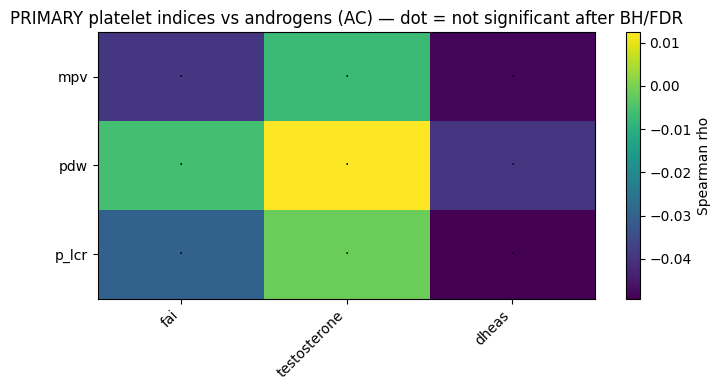

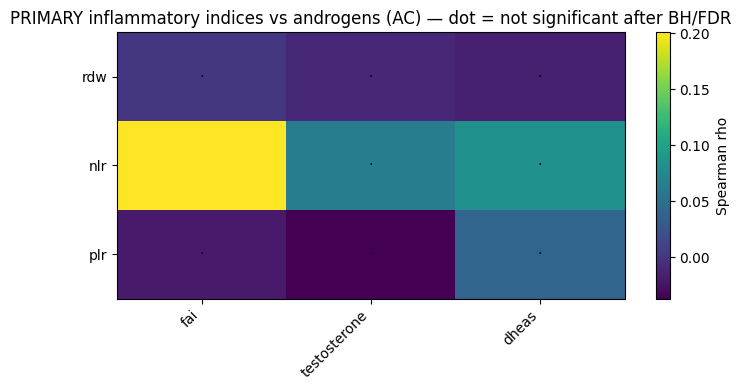

In [16]:
def heatmap_from_corr(corr_df: pd.DataFrame, x_order: list[str], y_order: list[str],
                      title: str, q_thresh=0.05, outpath: Path | None = None):
    if corr_df.empty:
        print("No correlations to plot:", title)
        return None

    pivot = corr_df.pivot(index="y", columns="x", values="rho").reindex(index=y_order, columns=x_order)
    qmat  = corr_df.pivot(index="y", columns="x", values="q").reindex(index=y_order, columns=x_order)

    fig, ax = plt.subplots(figsize=(max(7, len(x_order)*1.1), max(4, len(y_order)*0.7)))
    im = ax.imshow(pivot.values, aspect="auto")

    ax.set_xticks(range(len(x_order)))
    ax.set_xticklabels(x_order, rotation=45, ha="right")
    ax.set_yticks(range(len(y_order)))
    ax.set_yticklabels(y_order)
    ax.set_title(title)

    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            q = qmat.iloc[i, j]
            if pd.isna(q) or q > q_thresh:
                ax.text(j, i, "·", ha="center", va="center")

    fig.colorbar(im, ax=ax, label="Spearman rho")
    plt.tight_layout()

    if outpath is not None:
        fig.savefig(outpath, dpi=200)
    return fig

heatmap_from_corr(
    corr_platelet_ac, PRIMARY_ANDROGENS, PRIMARY_PLATELET,
    "PRIMARY platelet indices vs androgens (AC) — dot = not significant after BH/FDR",
    outpath=OUT_DIR / "heatmap_PRIMARY_platelet_AC.png"
)
heatmap_from_corr(
    corr_inflam_ac, PRIMARY_ANDROGENS, PRIMARY_INFLAM,
    "PRIMARY inflammatory indices vs androgens (AC) — dot = not significant after BH/FDR",
    outpath=OUT_DIR / "heatmap_PRIMARY_inflam_AC.png"
)
plt.show()


## Regression reporting

Regression results are reported as β coefficients with HC3-robust standard errors and corresponding 95% confidence intervals.
Benjamini–Hochberg FDR correction is applied within each pre-defined model family (within dataset and adjustment set).


## OLS regressions with HC3 (crude / +IR / +IR+age) + BH/FDR per model

In [17]:
Z_975 = 1.959963984540054  # 97.5th percentile of N(0,1), for 95% CI

def fit_ols_hc3(df: pd.DataFrame, outcome: str, predictors: list[str], min_n=80):
    cols = [outcome] + predictors
    d = df[cols].dropna().copy()
    if len(d) < min_n:
        return None, None
    X = sm.add_constant(d[predictors])
    y = d[outcome]
    return sm.OLS(y, X).fit(cov_type="HC3"), d

def run_family_models(df: pd.DataFrame, outcomes: list[str], androgens: list[str],
                      ir_cov: str = None, age_cov: str = None, tag: str = "AC",
                      min_n=80) -> pd.DataFrame:
    rows = []

    def add_row(m, d_used, y, a, model_label):
        beta = float(m.params.get(a, np.nan))
        se   = float(m.bse.get(a, np.nan))
        pval = float(m.pvalues.get(a, np.nan))

        ci_low  = beta - Z_975 * se
        ci_high = beta + Z_975 * se

        return {
            "dataset": tag, "outcome": y, "androgen": a, "model": model_label,
            "n": int(m.nobs),
            "beta_androgen": beta,
            "se_HC3": se,
            "ci95_low": ci_low,
            "ci95_high": ci_high,
            "p_androgen": pval,
            "r2": float(m.rsquared)
        }

    for a in androgens:
        for y in outcomes:
            if a not in df.columns or y not in df.columns:
                continue

            m1, d1 = fit_ols_hc3(df, y, [a], min_n=min_n)
            if m1 is not None:
                rows.append(add_row(m1, d1, y, a, "crude"))

            if ir_cov is not None and ir_cov in df.columns:
                m2, d2 = fit_ols_hc3(df, y, [a, ir_cov], min_n=min_n)
                if m2 is not None:
                    rows.append(add_row(m2, d2, y, a, f"+{ir_cov}"))

            if (ir_cov is not None and ir_cov in df.columns) and (age_cov is not None and age_cov in df.columns):
                m3, d3 = fit_ols_hc3(df, y, [a, ir_cov, age_cov], min_n=min_n)
                if m3 is not None:
                    rows.append(add_row(m3, d3, y, a, f"+{ir_cov}+{age_cov}"))

    out = pd.DataFrame(rows)
    if out.empty:
        return out

    out["q_androgen"] = np.nan
    for (ds, model), idx in out.groupby(["dataset","model"]).groups.items():
        out.loc[idx, "q_androgen"] = multipletests(out.loc[idx, "p_androgen"], method="fdr_bh")[1]

    return out.sort_values(["dataset","model","q_androgen","p_androgen"])


reg_primary_ac = pd.concat([
    run_family_models(ac, PRIMARY_PLATELET, PRIMARY_ANDROGENS, ir_cov=IR_COV, age_cov=AGE_COV, tag="AC_platelet"),
    run_family_models(ac, PRIMARY_INFLAM,   PRIMARY_ANDROGENS, ir_cov=IR_COV, age_cov=AGE_COV, tag="AC_inflam")
], ignore_index=True)

reg_primary_cc = pd.concat([
    run_family_models(cc, PRIMARY_PLATELET, PRIMARY_ANDROGENS, ir_cov=IR_COV, age_cov=AGE_COV, tag="CC_platelet"),
    run_family_models(cc, PRIMARY_INFLAM,   PRIMARY_ANDROGENS, ir_cov=IR_COV, age_cov=AGE_COV, tag="CC_inflam")
], ignore_index=True)

reg_primary = pd.concat([reg_primary_ac, reg_primary_cc], ignore_index=True)
reg_primary.to_csv(OUT_DIR / "REG_primary_models_HC3.csv", index=False)

display(reg_primary.head(40))


,dataset,outcome,androgen,model,n,beta_androgen,se_HC3,ci95_low,ci95_high,p_androgen,r2,q_androgen
0,AC_platelet,mpv,fai,+log_homa_ir,887,-0.060659,0.025518,-0.110674,-0.010644,0.017451,0.005209,0.128611
1,AC_platelet,p_lcr,fai,+log_homa_ir,887,-0.450637,0.213821,-0.869718,-0.031557,0.035070,0.003925,0.128611
2,AC_platelet,pdw,fai,+log_homa_ir,888,-0.106249,0.052469,-0.209086,-0.003411,0.042870,0.003137,0.128611
3,AC_platelet,mpv,dheas,+log_homa_ir,886,-0.000340,0.000217,-0.000765,0.000085,0.117215,0.003079,0.184181
4,AC_platelet,pdw,dheas,+log_homa_ir,887,-0.000731,0.000468,-0.001649,0.000187,0.118436,0.002625,0.184181
5,AC_platelet,p_lcr,dheas,+log_homa_ir,886,-0.002778,0.001800,-0.006307,0.000750,0.122787,0.002657,0.184181
6,AC_platelet,mpv,testosterone,+log_homa_ir,888,-0.148130,0.156150,-0.454179,0.157919,0.342804,0.001524,0.439994
7,AC_platelet,pdw,testosterone,+log_homa_ir,889,-0.281435,0.328161,-0.924619,0.361748,0.391106,0.000881,0.439994
8,AC_platelet,p_lcr,testosterone,+log_homa_ir,888,-1.004537,1.310363,-3.572802,1.563728,0.443314,0.000823,0.443314
9,AC_platelet,mpv,fai,+log_homa_ir+age,887,-0.060904,0.025637,-0.111151,-0.010656,0.017519,0.005292,0.129386


For regression analyses, Benjamini–Hochberg FDR correction is applied within each model family,
defined as all androgen–outcome tests within the same dataset (AC/CC) and adjustment set (crude / IR / IR+age).


## Cook’s distance QC (dla IR-adjusted)

In [18]:
def cooks_distance_summary(df, outcome, predictors, min_n=80):
    d = df[[outcome] + predictors].dropna().copy()
    if len(d) < min_n:
        return None
    X = sm.add_constant(d[predictors])
    model = sm.OLS(d[outcome], X).fit()
    infl = model.get_influence()
    cooks = infl.cooks_distance[0]
    threshold = 4 / len(d)
    return {
        "outcome": outcome,
        "predictors": "+".join(predictors),
        "n": len(d),
        "cooks_threshold_4_over_n": float(threshold),
        "n_above_threshold": int((cooks > threshold).sum()),
        "max_cooks": float(np.max(cooks))
    }

rows = []
if IR_COV is not None:
    for a in PRIMARY_ANDROGENS:
        for y in (PRIMARY_PLATELET + PRIMARY_INFLAM):
            s = cooks_distance_summary(ac, y, [a, IR_COV])
            if s:
                rows.append(s)

cooks_df = pd.DataFrame(rows)
cooks_df.to_csv(OUT_DIR / "QC_cooks_distance_primary_AC.csv", index=False)
display(cooks_df.head(20))


,outcome,predictors,n,cooks_threshold_4_over_n,n_above_threshold,max_cooks
0,mpv,fai+log_homa_ir,887,0.004510,42,0.032944
1,pdw,fai+log_homa_ir,888,0.004505,37,0.033406
2,p_lcr,fai+log_homa_ir,887,0.004510,40,0.030592
3,rdw,fai+log_homa_ir,887,0.004510,37,0.050711
4,nlr,fai+log_homa_ir,887,0.004510,35,0.084051
5,plr,fai+log_homa_ir,887,0.004510,33,0.059800
6,mpv,testosterone+log_homa_ir,888,0.004505,45,0.044618
7,pdw,testosterone+log_homa_ir,889,0.004499,42,0.039881
8,p_lcr,testosterone+log_homa_ir,888,0.004505,44,0.049316
9,rdw,testosterone+log_homa_ir,888,0.004505,37,0.156763


## Descriptives

In [19]:
def descriptive_table(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    rows = []
    for v in variables:
        if v not in df.columns:
            continue
        s = pd.to_numeric(df[v], errors="coerce").dropna()
        if len(s) == 0:
            continue

        sh_p = np.nan
        if len(s) >= 3:
            ss = s.sample(min(len(s), 5000), random_state=RANDOM_SEED)
            sh_p = float(stats.shapiro(ss)[1])

        rows.append({
            "variable": v,
            "n": int(len(s)),
            "mean": float(np.mean(s)),
            "sd": float(np.std(s, ddof=1)) if len(s) > 1 else np.nan,
            "median": float(np.median(s)),
            "iqr25": float(np.percentile(s, 25)),
            "iqr75": float(np.percentile(s, 75)),
            "min": float(np.min(s)),
            "max": float(np.max(s)),
            "missing_pct": float(pd.isna(df[v]).mean() * 100),
            "shapiro_p_(sample<=5000)": sh_p
        })
    return pd.DataFrame(rows).sort_values("variable")

DESCRIBE_VARS = sorted(set(
    PRIMARY_ANDROGENS +
    ["shbg","lh","fsh","lh_fsh"] +
    ["insulin","glucose_0","homa_ir","log_homa_ir","quicki","tyg"] +
    PRIMARY_PLATELET + PRIMARY_INFLAM + SECONDARY_CBC +
    (["age"] if AGE_COV else [])
).intersection(ac.columns))

desc_ac = descriptive_table(ac, DESCRIBE_VARS)
desc_ac.to_csv(OUT_DIR / "DESCRIPTIVES_AC.csv", index=False)

display(desc_ac.head(30))


,variable,n,mean,sd,median,iqr25,iqr75,min,max,missing_pct,shapiro_p_(sample<=5000)
0,age,1300,20.923077,1.948985,21.000000,19.000000,22.000000,16.000000,25.000000,0.000000,4.248996e-20
1,dheas,1162,338.012823,133.613671,319.500000,245.000000,415.000000,30.900000,935.000000,10.615385,1.452565e-16
2,fai,1159,1.119663,1.083844,0.782710,0.448891,1.400350,0.035795,10.097087,10.846154,1.084252e-39
3,fsh,1172,5.979923,1.981375,5.790000,4.937500,6.872500,0.620000,47.600000,9.846154,2.469762e-41
4,glucose_0,1160,84.359138,6.058847,83.900000,80.300000,88.000000,51.900000,108.000000,10.769231,1.178244e-08
5,homa_ir,967,1.921844,1.495133,1.527733,1.080886,2.288037,0.148889,20.905185,25.615385,3.830986e-40
6,insulin,975,9.130144,6.824323,7.370000,5.300000,10.900000,0.400000,98.200000,25.000000,5.000247e-40
7,lh,1176,8.461896,5.558979,7.070000,4.910000,10.300000,0.100000,60.610000,9.538462,8.360783e-34
8,lh_fsh,1171,1.420999,0.846969,1.201133,0.870213,1.765028,0.054632,6.494118,9.923077,2.658640e-31
9,log_homa_ir,967,0.469471,0.582950,0.423785,0.077781,0.827692,-1.904555,3.039997,25.615385,2.127881e-05


In [20]:

reg_primary.to_csv(OUT_DIR / "PRIMARY_RESULTS_all_models.csv", index=False)

if IR_COV is not None:
    wanted_models = [f"+{IR_COV}"]
    if AGE_COV:
        wanted_models.append(f"+{IR_COV}+{AGE_COV}")
    primary_main = reg_primary[reg_primary["model"].isin(wanted_models)].copy()
else:
    primary_main = reg_primary[reg_primary["model"] == "crude"].copy()

primary_main.to_csv(OUT_DIR / "PRIMARY_RESULTS_main_model.csv", index=False)
display(primary_main.head(40))


S3_DIR = OUT_DIR / "S3"
S3_DIR.mkdir(parents=True, exist_ok=True)


reg_primary.to_csv(S3_DIR / "S3_REG_primary_models_HC3_with_CI95.csv", index=False)
primary_main.to_csv(S3_DIR / "S3_PRIMARY_RESULTS_main_model.csv", index=False)
reg_primary.to_csv(S3_DIR / "S3_PRIMARY_RESULTS_all_models.csv", index=False)



if IR_COV is not None and AGE_COV is not None:
    MAIN_MODEL = f"+{IR_COV}+{AGE_COV}"
elif IR_COV is not None:
    MAIN_MODEL = f"+{IR_COV}"
else:
    MAIN_MODEL = "crude"

pm = reg_primary[reg_primary["model"] == MAIN_MODEL].copy()


pm["beta_ci95"] = pm.apply(
    lambda r: f'{r["beta_androgen"]:.3g} ({r["ci95_low"]:.3g}, {r["ci95_high"]:.3g})',
    axis=1
)


pm_out = pm[[
    "dataset", "outcome", "androgen", "n",
    "beta_ci95", "p_androgen", "q_androgen", "r2"
]].sort_values(["dataset", "outcome", "q_androgen", "p_androgen"])

pm_out.to_excel(S3_DIR / "S3_TABLE_manuscript_ready_main_model.xlsx", index=False)

print("DONE. Outputs saved to:", OUT_DIR.resolve())
print("S3 outputs saved to:", S3_DIR.resolve())
print("Manuscript-ready table:", (S3_DIR / "S3_TABLE_manuscript_ready_main_model.xlsx").resolve())


,dataset,outcome,androgen,model,n,beta_androgen,se_HC3,ci95_low,ci95_high,p_androgen,r2,q_androgen
0,AC_platelet,mpv,fai,+log_homa_ir,887,-0.060659,0.025518,-0.110674,-0.010644,0.017451,0.005209,0.128611
1,AC_platelet,p_lcr,fai,+log_homa_ir,887,-0.450637,0.213821,-0.869718,-0.031557,0.035070,0.003925,0.128611
2,AC_platelet,pdw,fai,+log_homa_ir,888,-0.106249,0.052469,-0.209086,-0.003411,0.042870,0.003137,0.128611
3,AC_platelet,mpv,dheas,+log_homa_ir,886,-0.000340,0.000217,-0.000765,0.000085,0.117215,0.003079,0.184181
4,AC_platelet,pdw,dheas,+log_homa_ir,887,-0.000731,0.000468,-0.001649,0.000187,0.118436,0.002625,0.184181
5,AC_platelet,p_lcr,dheas,+log_homa_ir,886,-0.002778,0.001800,-0.006307,0.000750,0.122787,0.002657,0.184181
6,AC_platelet,mpv,testosterone,+log_homa_ir,888,-0.148130,0.156150,-0.454179,0.157919,0.342804,0.001524,0.439994
7,AC_platelet,pdw,testosterone,+log_homa_ir,889,-0.281435,0.328161,-0.924619,0.361748,0.391106,0.000881,0.439994
8,AC_platelet,p_lcr,testosterone,+log_homa_ir,888,-1.004537,1.310363,-3.572802,1.563728,0.443314,0.000823,0.443314
9,AC_platelet,mpv,fai,+log_homa_ir+age,887,-0.060904,0.025637,-0.111151,-0.010656,0.017519,0.005292,0.129386


DONE. Outputs saved to: /content/outputs
S3 outputs saved to: /content/outputs/S3
Manuscript-ready table: /content/outputs/S3/S3_TABLE_manuscript_ready_main_model.xlsx
